In [1]:
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()

data_dir = Path.cwd() / "data"

In [2]:
from langchain.document_loaders import PyPDFLoader

brand_name = "nevaris"

# filename = "Allplan_2020_Manual.pdf"
# filename = "Graphisoft_Archicad_manual.pdf"
filename = "Nevaris-Build-HelpPages-Complete.pdf"

loader = PyPDFLoader(f"{data_dir}/{filename}")

raw_data = loader.load()
print(len(raw_data))  # number of pages loaded

370


In [3]:
texts = [page.page_content for page in raw_data]

texts = " ".join(texts)
texts = texts.replace("\n", "")

In [4]:
from chonkie import SentenceChunker

chunker = SentenceChunker(
    tokenizer="gpt2",            
    chunk_size=500,                 
    chunk_overlap=50,               
    min_sentences_per_chunk=1        
)

chunks = chunker(texts)

docs = [chunk.text for chunk in chunks]

print(len(docs))  # Should match the number of chunks

634


# GraphRAG

In [5]:
import numpy as np
from langchain_google_vertexai import VertexAIEmbeddings
# from langchain_google_vertexai import ChatVertexAI

# llm = ChatVertexAI(model_name="gemini-2.5-flash", temperature=0.1, thinking_budget=0)

embedding_model = VertexAIEmbeddings(
    model_name="text-embedding-005"
)

embeddings = embedding_model.embed_documents(docs)

print(len(embeddings))

embeddings = np.array(embeddings)

/Users/avosseler/Github_priv/graph-rag/.venv/lib/python3.12/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


634


In [6]:
from graph_rag import KnowledgeGraph

kg = KnowledgeGraph()

# Extract concepts for all chunks (batch)
concepts_per_chunk = kg.extract_concepts_batch(docs=docs)

# Create knowledge graph
G = kg.create_graph(
            embeddings=embeddings,
            docs=docs,
            concepts_per_chunk=concepts_per_chunk,
            k=5,
            metric="IP",
            save_dir=data_dir / "kg_graph" / brand_name,
            similarity_threshold=0.5,  # Only keep edges with cosine similarity >= 0.5
            concept_weight=0.3,  # 30% weight to concept overlap similarity metric
)

2025-11-01 13:53:23,442 - graph_rag - INFO - Initializing KnowledgeGraph 📈
2025-11-01 13:53:23,442 - graph_rag - INFO - Loading GLiNER NER model...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/avosseler/Github_priv/graph-rag/.venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Extracting concepts / NER: 100%|██████████| 7/7 [01:50<00:00, 15.78s/it]
2025-11-01 13:55:18,106 - graph_rag - INFO - Saving adjacency list to directory: /Users/avosseler/Github_priv/graph-rag/data/kg_graph/nevaris
2025-11-01 13:55:18,106 - graph_rag - INFO - Building kNN graph: 634 nodes, k=5, metric=IP


  Applying threshold: IP >=0.5


Building edges: 100%|██████████| 634/634 [00:00<00:00, 23423.20it/s]

✓ Created 3091 edges
  Saved to: /Users/avosseler/Github_priv/graph-rag/data/kg_graph/nevaris/graph_adjlist.txt
  Distance stats: mean=0.911, std=0.043
  Distance range: [0.764, 1.000]
Graph topology with concept enhancement:
  Nodes: 634
  Edges: 2258
  Avg degree: 7.12


Visualize graph:

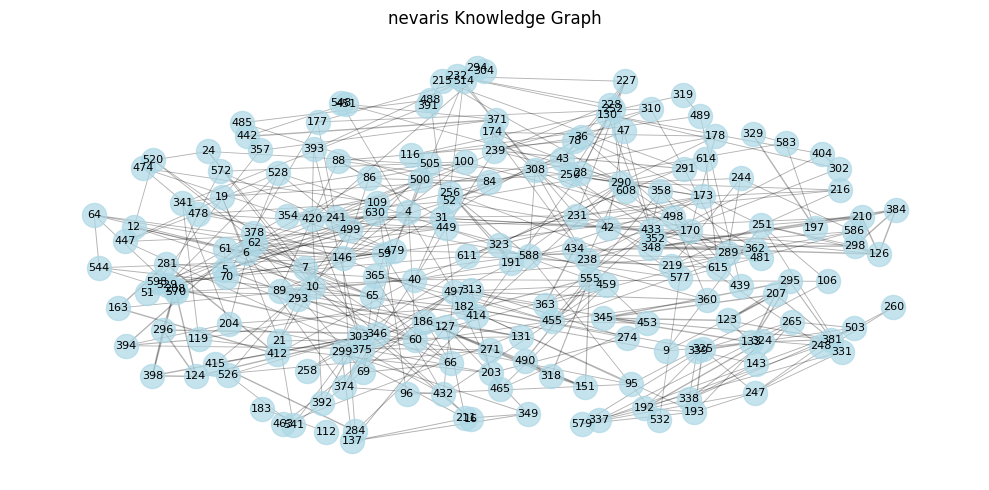

In [7]:
# Now plot
kg.visualize_graph_simple(G, max_nodes=200, title=f"{brand_name} Knowledge Graph", seed=42)

In [8]:
print("Nodes:", kg.nx_graph.number_of_nodes())
print("Edges:", kg.nx_graph.number_of_edges())

print("Sample nodes:", list(kg.nx_graph.nodes(data=True))[:3])
print("Sample edges:", list(kg.nx_graph.edges(data=True))[:3])

Nodes: 634
Edges: 2258
Sample nodes: [(0, {'content': 'Online-Hilfe für NEVARIS Build8      Erste Schritte9           Installation10           Benutzeroberfläche11                Anwendungen12                Anwendungsbereiche13                Anwendungsrahmen14                Detailbereich15                Hauptbereich16                Hinweise17                Infoleiste18                Linke Seitenleiste19                Meldungen21                Menüleiste22                Prozesse23                Prozessschritte24                Rechte Seitenleiste25                Register27                Schaltflächen28                Schnellzugriff29                Statusleiste30           Grundlegendes31                Tabellarische Darstellung32                Funktionen - LV Bearbeitung34                Mengen ermitteln36                     Spalten (Mengen ermitteln)37                     Funktionen (Mengen ermitteln)38                     Navigation (Mengen ermitteln)39                

## Create a single GraphDocument from nodes and relationships:
This will hold all nodes and therelationships extracted from networkX graph object.

In [10]:
# import networkx as nx
# from langchain_core.documents import Document
# from langchain_community.graphs.graph_document import Node, Relationship, GraphDocument

# # 1. Convert nodes
# lc_nodes = []
# node_lookup = {}  # To reuse Node objects in relationships

# for node_id, attrs in kg.nx_graph.nodes(data=True):
#     node_type = attrs.get("type", "Node")
#     properties = {k: v for k, v in attrs.items() if k != "type"}
#     node = Node(id=str(node_id), type=node_type, properties=properties)
#     lc_nodes.append(node)
#     node_lookup[str(node_id)] = node

# # 2. Convert edges using Node objects
# lc_relationships = []
# for source, target, attrs in kg.nx_graph.edges(data=True):
#     rel_type = attrs.get("type", "RELATED_TO")
#     properties = {k: v for k, v in attrs.items() if k != "type"}
    
#     source_node = node_lookup[str(source)]
#     target_node = node_lookup[str(target)]
    
#     lc_relationships.append(
#         Relationship(
#             source=source_node,
#             target=target_node,
#             type=rel_type,
#             properties=properties,
#         )
#     )

# # 3. Create a Document for the source
# source_doc = Document(
#     page_content="NetworkX graph conversion",  # Or any meaningful content
#     metadata={"source": "networkx_graph"}  # Optional metadata
# )

# # 4. Construct GraphDocument
# graph_doc = GraphDocument(
#     nodes=lc_nodes,
#     relationships=lc_relationships,
#     source=source_doc
# )

# graph_documents_filtered = [graph_doc]  # Assuming we have only one graph document here

In [78]:
# from google.cloud import spanner

# spanner_client = spanner.Client()
# instance = spanner_client.instance(SPANNER_INSTANCE_ID)
# database = instance.database(SPANNER_DATABASE_ID)

# operation = database.update_ddl([
#     """
#     CREATE TABLE KgEdge (
#       SourceId    INT64 NOT NULL,
#       TargetId    INT64 NOT NULL,
#       Type        STRING(128),
#       Properties  STRING(MAX)
#     ) PRIMARY KEY (SourceId, TargetId)
#     """
# ])
# operation.result()  # Wait for completion
# print("KgEdge table created.")

In [9]:
# --- 1. Convert nodes for GraphDocument and prepare Spanner rows ---
import networkx as nx
from langchain_core.documents import Document
from langchain_community.graphs.graph_document import Node, Relationship, GraphDocument
import json

lc_nodes = []
node_lookup = {}  # To reuse Node objects in relationships
spanner_node_rows = []

for node_id, attrs in kg.nx_graph.nodes(data=True):
    node_type = attrs.get("type", "Node")
    properties = {k: v for k, v in attrs.items() if k != "type"}
    node = Node(id=str(node_id), type=node_type, properties=properties)
    lc_nodes.append(node)
    node_lookup[str(node_id)] = node

    # Prepare Spanner node row
    spanner_node_rows.append({
        "NodeId": int(node_id),
        "Type": node_type,
        "Content": attrs.get("content", ""),
        "Embedding": attrs.get("embedding", []),
        "Concepts": attrs.get("concepts", []),
        "DegCentrality": attrs.get("deg_centrality", 0.0),
        "Closeness": attrs.get("closeness_centrality", 0.0),
        "Betweenness": attrs.get("betweenness_centrality", 0.0),
        "Eigenvector": attrs.get("eigenvector_centrality", 0.0),
    })

# --- 2. Convert edges for GraphDocument and prepare Spanner rows (undirected/weighted) ---
lc_relationships = []
spanner_edge_rows = []

for source, target, attrs in kg.nx_graph.edges(data=True):
    rel_type = attrs.get("type", "RELATED_TO")
    properties = {k: v for k, v in attrs.items() if k != "type"}
    # Add weight to properties if present
    if "weight" in attrs:
        properties["weight"] = attrs["weight"]

    source_node = node_lookup[str(source)]
    target_node = node_lookup[str(target)]

    # Add both directions for undirected graph
    for src, tgt in [(source, target), (target, source)]:
        lc_relationships.append(
            Relationship(
                source=node_lookup[str(src)],
                target=node_lookup[str(tgt)],
                type=rel_type,
                properties=properties,
            )
        )
        spanner_edge_rows.append({
            "SourceId": int(src),
            "TargetId": int(tgt),
            "Type": rel_type,
            "Properties": json.dumps(properties),
        })

# --- 3. Create a Document for the source ---
source_doc = Document(
    page_content="NetworkX graph conversion",
    metadata={"source": "networkx_graph"}
)

# --- 4. Construct GraphDocument ---
graph_doc = GraphDocument(
    nodes=lc_nodes,
    relationships=lc_relationships,
    source=source_doc
)

graph_documents_filtered = [graph_doc]

In [10]:
# Diagnostic check
print("="*50)
print("DIAGNOSTICS")
print("="*50)
print(f"NetworkX graph type: {type(kg.nx_graph)}")
print(f"Nodes: {kg.nx_graph.number_of_nodes()}")
print(f"Edges: {kg.nx_graph.number_of_edges()}")
print(f"\nlc_nodes count: {len(lc_nodes)}")
print(f"lc_relationships count: {len(lc_relationships)}")
print(f"\nGraphDocument:")
print(f"  - nodes: {len(graph_doc.nodes)}")
print(f"  - relationships: {len(graph_doc.relationships)}")
print(f"  - source: {graph_doc.source}")

if lc_nodes:
    print(f"\nSample Node: {lc_nodes[0]}")
if lc_relationships:
    print(f"\nSample Relationship: {lc_relationships[0]}")


DIAGNOSTICS
NetworkX graph type: <class 'networkx.classes.graph.Graph'>
Nodes: 634
Edges: 2258

lc_nodes count: 634
lc_relationships count: 4516

GraphDocument:
  - nodes: 634
  - relationships: 4516
  - source: page_content='NetworkX graph conversion' metadata={'source': 'networkx_graph'}

Sample Node: id='0' properties={'content': 'Online-Hilfe für NEVARIS Build8      Erste Schritte9           Installation10           Benutzeroberfläche11                Anwendungen12                Anwendungsbereiche13                Anwendungsrahmen14                Detailbereich15                Hauptbereich16                Hinweise17                Infoleiste18                Linke Seitenleiste19                Meldungen21                Menüleiste22                Prozesse23                Prozessschritte24                Rechte Seitenleiste25                Register27                Schaltflächen28                Schnellzugriff29                Statusleiste30           Grundlegendes31          

In [11]:
graph_documents_filtered[0].nodes[:5]

[Node(id='0', properties={'content': 'Online-Hilfe für NEVARIS Build8      Erste Schritte9           Installation10           Benutzeroberfläche11                Anwendungen12                Anwendungsbereiche13                Anwendungsrahmen14                Detailbereich15                Hauptbereich16                Hinweise17                Infoleiste18                Linke Seitenleiste19                Meldungen21                Menüleiste22                Prozesse23                Prozessschritte24                Rechte Seitenleiste25                Register27                Schaltflächen28                Schnellzugriff29                Statusleiste30           Grundlegendes31                Tabellarische Darstellung32                Funktionen - LV Bearbeitung34                Mengen ermitteln36                     Spalten (Mengen ermitteln)37                     Funktionen (Mengen ermitteln)38                     Navigation (Mengen ermitteln)39                     Optionen (Me

In [15]:
#graph_documents_filtered[0].relationships

In [12]:
GCP_PROJECT_ID = "neme-ai-rnd-dev-prj-01"
REGION = "europe-west3" 
# MODEL_NAME = "gemini-2.0-flash"  
# EMBEDDING_MODEL_NAME = "text-embedding-005"  
TASK_TYPE = "SEMANTIC_SIMILARITY" 
ANSWER_TASK_TYPE = "RETRIEVAL_DOCUMENT"  
SPANNER_INSTANCE_ID = "graphrag-instance-new"  
SPANNER_DATABASE_ID = f"graphrag-{brand_name}"  
SPANNER_GRAPH_NAME = brand_name

Create a spanner database

In [ ]:
# Create a spanner database and table to store the graph with nodes and edges created in graph
def create_database(project_id, instance_id, database_id):
    """
    Creates a database and tables for graph data.
    """
    from google.cloud import spanner
    from google.cloud.spanner_admin_database_v1.types import spanner_database_admin

    spanner_client = spanner.Client(project_id)
    database_admin_api = spanner_client.database_admin_api

    request = spanner_database_admin.CreateDatabaseRequest(
        parent=database_admin_api.instance_path(spanner_client.project, instance_id),
        create_statement=f"CREATE DATABASE `{database_id}`",
        # extra_statements=[
        #     f"""
        #     CREATE TABLE {node_table_name} (
        #         NodeId        INT64 NOT NULL,
        #         Type          STRING(128),
        #         Content       STRING(MAX),
        #         Embedding     ARRAY<FLOAT64>,
        #         Concepts      ARRAY<STRING(MAX)>,
        #         DegCentrality FLOAT64,
        #         Closeness     FLOAT64,
        #         Betweenness   FLOAT64,
        #         Eigenvector   FLOAT64
        #     ) PRIMARY KEY (NodeId)
        #     """,
        #     f"""
        #     CREATE TABLE {edge_table_name} (
        #         SourceId   INT64 NOT NULL,
        #         TargetId   INT64 NOT NULL,
        #         Type       STRING(128),
        #         Properties STRING(MAX)
        #     ) PRIMARY KEY (SourceId, TargetId)
        #     """
        # ],
    )

    operation = database_admin_api.create_database(request=request)
    print("Waiting for operation to complete...")
    OPERATION_TIMEOUT_SECONDS = 60
    database = operation.result(OPERATION_TIMEOUT_SECONDS)
    print(
        f"Created database: {database.name}"
    )
    print(f"On instance: {database_admin_api.instance_path(spanner_client.project, instance_id)}")
    
# Run:
create_database(GCP_PROJECT_ID, SPANNER_INSTANCE_ID, SPANNER_DATABASE_ID)

Select all spanner tables

In [27]:
from google.cloud import spanner

spanner_client = spanner.Client()
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)

with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        "SELECT table_name FROM information_schema.tables WHERE table_catalog = '' AND table_schema = '';"
    )
    for row in results:
        print(row[0])

Created multiplexed session.
Created multiplexed session.
Created multiplexed session.


Archicad_Node
Archicad_Node_RELATED_TO_Node
KgEdge
KgNode


Drop tables:

In [29]:
# from google.cloud import spanner

# spanner_client = spanner.Client()
# instance = spanner_client.instance(SPANNER_INSTANCE_ID)
# database = instance.database(SPANNER_DATABASE_ID)

# table_name1 = "Allplan_Node"
# table_name2 = "Allplan_Node_RELATED_TO_Node"

# operation = database.update_ddl([
#     f"DROP TABLE {table_name2}",  # Drop child first
#     f"DROP TABLE {table_name1}",  # Then parent
# ])
# operation.result()  # Wait for completion
# print("Tables KgNode and KgEdge dropped.")

Create tables:

In [15]:
from google.cloud import spanner

spanner_client = spanner.Client()
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)

operation = database.update_ddl([
    """
    CREATE TABLE KgNode (
        NodeId        INT64 NOT NULL,
        Type          STRING(128),
        Content       STRING(MAX),
        Embedding     ARRAY<FLOAT64>,
        Concepts      ARRAY<STRING(MAX)>,
        DegCentrality FLOAT64,
        Closeness     FLOAT64,
        Betweenness   FLOAT64,
        Eigenvector   FLOAT64
    ) PRIMARY KEY (NodeId)
    """,
    """
    CREATE TABLE KgEdge (
        SourceId   INT64 NOT NULL,
        TargetId   INT64 NOT NULL,
        Type       STRING(128),
        Properties STRING(MAX)
    ) PRIMARY KEY (SourceId, TargetId)
    """
])
operation.result()  # Wait for completion
print("Tables KgNode and KgEdge created.")

Tables KgNode and KgEdge created.


Insert / Replace table data:

In [16]:
# --- 5. Robust Spanner ingestion ---
from google.cloud import spanner

spanner_client = spanner.Client()
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)

# Ensure all keys are present in every row (robust against missing attributes)
spanner_node_rows_fixed = []
for row in spanner_node_rows:
    spanner_node_rows_fixed.append({
        "NodeId": row.get("NodeId", 0),
        "Type": row.get("Type", "Node"),
        "Content": row.get("Content", ""),
        "Embedding": row.get("Embedding", []),
        "Concepts": row.get("Concepts", []),
        "DegCentrality": row.get("DegCentrality", 0.0),
        "Closeness": row.get("Closeness", 0.0),
        "Betweenness": row.get("Betweenness", 0.0),
        "Eigenvector": row.get("Eigenvector", 0.0),
    })

spanner_edge_rows_fixed = []
for row in spanner_edge_rows:
    spanner_edge_rows_fixed.append({
        "SourceId": row.get("SourceId", 0),
        "TargetId": row.get("TargetId", 0),
        "Type": row.get("Type", "RELATED_TO"),
        "Properties": row.get("Properties", "{}"),
    })

import math

def chunked(iterable, size):
    for i in range(0, len(iterable), size):
        yield iterable[i:i+size]

BATCH_SIZE = 1000  # Adjust as needed to stay under mutation limit

# Insert nodes in batches
for node_chunk in chunked(spanner_node_rows_fixed, BATCH_SIZE):
    with database.batch() as batch:
        batch.replace(
            table="KgNode",
            columns=["NodeId", "Type", "Content", "Embedding", "Concepts", "DegCentrality", "Closeness", "Betweenness", "Eigenvector"],
            values=[
                (
                    row["NodeId"], row["Type"], row["Content"], row["Embedding"], row["Concepts"],
                    row["DegCentrality"], row["Closeness"], row["Betweenness"], row["Eigenvector"]
                ) for row in node_chunk
            ]
        )

# Insert edges in batches
for edge_chunk in chunked(spanner_edge_rows_fixed, BATCH_SIZE):
    with database.batch() as batch:
        batch.replace(
            table="KgEdge",
            columns=["SourceId", "TargetId", "Type", "Properties"],
            values=[
                (
                    row["SourceId"], row["TargetId"], row["Type"], row["Properties"]
                ) for row in edge_chunk
            ]
        )

Created multiplexed session.


Create Spanner instance:

In [43]:
# !gcloud services enable spanner.googleapis.com
# !gcloud spanner instances create {SPANNER_INSTANCE_ID} --config=regional-europe-west3 --description="Graph RAG Instance" --nodes=1 --edition=ENTERPRISE

In [17]:
from langchain_google_spanner import SpannerGraphStore

graph_store = SpannerGraphStore(
    instance_id=SPANNER_INSTANCE_ID,
    database_id=SPANNER_DATABASE_ID,
    graph_name=SPANNER_GRAPH_NAME,
)

Created multiplexed session.
Created multiplexed session.


Add graph data to Spanner:

In [19]:
# Uncomment the line below, if you want to cleanup from previous iterations.
# BeWARE - THIS COULD REMOVE DATA FROM YOUR DATABASE !!!

graph_store.cleanup()

for graph_document in graph_documents_filtered:
    graph_store.add_graph_documents([graph_document])

Waiting for DDL operations to complete...
Waiting for DDL operations to complete...
Insert nodes of type `Node`...
Insert nodes of type `Node`...
Insert edges of type `Node_RELATED_TO_Node`...
Insert edges of type `Node_RELATED_TO_Node`...


In [20]:
graph_store.get_structured_schema

{'Name of graph': 'nevaris',
 'Node properties per node label': {'Node': [{'name': 'concepts',
    'type': 'ARRAY<STRING>'},
   {'name': 'content', 'type': 'STRING'},
   {'name': 'embedding', 'type': 'ARRAY<FLOAT64>'},
   {'name': 'id', 'type': 'STRING'}]},
 'Edge properties per edge label': {'Node_RELATED_TO_Node': [{'name': 'id',
    'type': 'STRING'},
   {'name': 'shared_concepts', 'type': 'ARRAY<STRING>'},
   {'name': 'target_id', 'type': 'STRING'},
   {'name': 'weight', 'type': 'FLOAT64'}]},
 'Possible edges per label': {'Node_RELATED_TO_Node': ['(:Node) -[:Node_RELATED_TO_Node]-> (:Node)']}}

In [ ]:
# from langchain_google_spanner import SpannerGraphQAChain
# from langchain_google_vertexai import ChatVertexAI

# # Initialize llm object
# llm = ChatVertexAI(model=MODEL_NAME, temperature=0)

# # Initialize GraphQAChain
# chain = SpannerGraphQAChain.from_llm(
#     llm,
#     graph=graph_store,
#     allow_dangerous_requests=True,
#     # verbose=True,               # show intermediate steps
#     return_intermediate_steps=True,
# )

In [61]:
# question = "What is Allplan?"  
# question = "How can I configure the Actionbar in Allplan?"

# response = chain.invoke(input=question)

# print(response["result"])

In [21]:
from google.cloud import spanner

spanner_client = spanner.Client()
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)


with database.snapshot() as snapshot:
    results = list(snapshot.execute_sql("SELECT NodeId, Content FROM KgNode LIMIT 10"))
    for node_id, content in results:
        print(f"NodeId: {node_id}, Content: {content[:100]}")

Created multiplexed session.
Created multiplexed session.
Created multiplexed session.


NodeId: 0, Content: Online-Hilfe für NEVARIS Build8      Erste Schritte9           Installation10           Benutzerober
NodeId: 1, Content: Über das Suchfeld, die Quicklinks oder das Menü auf der linken Seite dieses Fensters gelangen Sie sc
NodeId: 2, Content: In der nachstehenden Übersicht werden die einzelnen Installationsmöglichkeiten kurz beschrieben.Einz
NodeId: 3, Content: Citrix zu betreiben.EntscheidungshilfeVerwenden Sie NEVARIS Build / Success X ohne NEVARIS Finance o
NodeId: 4, Content: Diese und weitere Infos finden Sie im Downloadbereich. Bevor Sie mit der Installation beginnen, ver
NodeId: 5, Content: Die Verfügbarkeit wird über die Lizenzen gesteuert.Klicken Sie auf die Liste Anwendung und entscheid
NodeId: 6, Content: zu verändern. Der Detailbereich gehört zurRegisteransicht Liste und ist z. B. in den Prozessschritte
NodeId: 7, Content: Sollte eine Aktion, die Sie im Programm ausführenwollten, nicht erfolgreich abgeschlossen werden kön
NodeId: 8, Content: Elementnamen

In [29]:
# steps = response.get("intermediate_steps", [])

# for step in steps:
#     if isinstance(step, dict) and "context" in step:
#         print("\n--- Retrieved Content ---")
#         for doc in step["context"]:
#             print(doc["content"])
#             print("-" * 40)

In [22]:
from langchain_google_spanner import SpannerGraphVectorContextRetriever
from langchain_google_vertexai import VertexAIEmbeddings

question = "How to install NevarisBuild?"

embedding_service = VertexAIEmbeddings(model_name="text-embedding-005")

retriever = SpannerGraphVectorContextRetriever.from_params(
    graph_store=graph_store,
    embedding_service=embedding_service,
    embeddings_column="Embedding",
    top_k=5,           # Number of vector similarity matches to return
    k=3,               # Number of graph results to return
    return_properties_list=["id", "content"],
    expand_by_hops=-1  # or set return_properties_list=["NodeId", "Content"] and expand_by_hops=-1
)

results = retriever.invoke(question)
results

/Users/avosseler/Github_priv/graph-rag/.venv/lib/python3.12/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


[Document(metadata={}, page_content='{"id": "4", "content": "Diese und weitere Infos finden Sie im Downloadbereich.\\uf1b3 Bevor Sie mit der Installation beginnen, vergewissern Sie sich, dass Sie sich f\\u00fcr das passende\\u202fInstallationsszenario\\u202fentschieden haben.\\uf1b3 11In den folgenden Unterpunkten sind die einzelnen Elemente der NEVARIS Build Benutzeroberfl\\u00e4che genauer beschrieben:AnwendungenAnwendungsbereicheAnwendungsrahmenDetailbereichHauptbereichHinweiseInfoleisteLinke SeitenleisteMeldungenMen\\u00fcleisteProzesseProzessschritteRechte SeitenleisteRegisterSchaltfl\\u00e4chenSchnellzugriffStatusleisteBenutzeroberfl\\u00e4cheBenutzerdefinierte Ansichten k\\u00f6nnen direkt in der Anwendung gespeichert werden (siehe im Hauptbereich rechts oben). Die unter \'Ansichten verwalten\' gespeicherten Ansichten in den verschiedenstenBereichen des Programms k\\u00f6nnen jeweils passend ex- und importiert werden. Somit k\\u00f6nnen die neuen Ansichtsdateien flexibel ausgeta

In [23]:
from langchain.chains import RetrievalQA
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model_name="gemini-2.0-flash", temperature=0.1)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
)
response = qa_chain.invoke({"query": question})
print(response["result"])

To install NEVARIS Build, follow these general steps:

1.  **Check System Requirements**: Ensure your system meets the recommended system requirements.
2.  **Choose the Right Installation Scenario**: Decide on the appropriate installation scenario for your company. A decision-making diagram is available if you are using NEVARIS Build / Success X without NEVARIS Finance or NEVARIS BIM.
3.  **Download the Setup Files**: Download the necessary setup files and a detailed installation guide from the download area.
4.  **Start the Setup**:
    *   Download the "Setup.exe" file from the download area.
    *   Open the file path.
    *   Start the file by double-clicking it. The files will be automatically unpacked.
    *   You will then see the setup start page "Select desired installation".
5.  **Follow the Installation Process**: The system will guide you step by step through the installation process.



Visualize the full knowledge graph from Spanner using NetworkX:

Created multiplexed session.
Created multiplexed session.
Created multiplexed session.
Created multiplexed session.


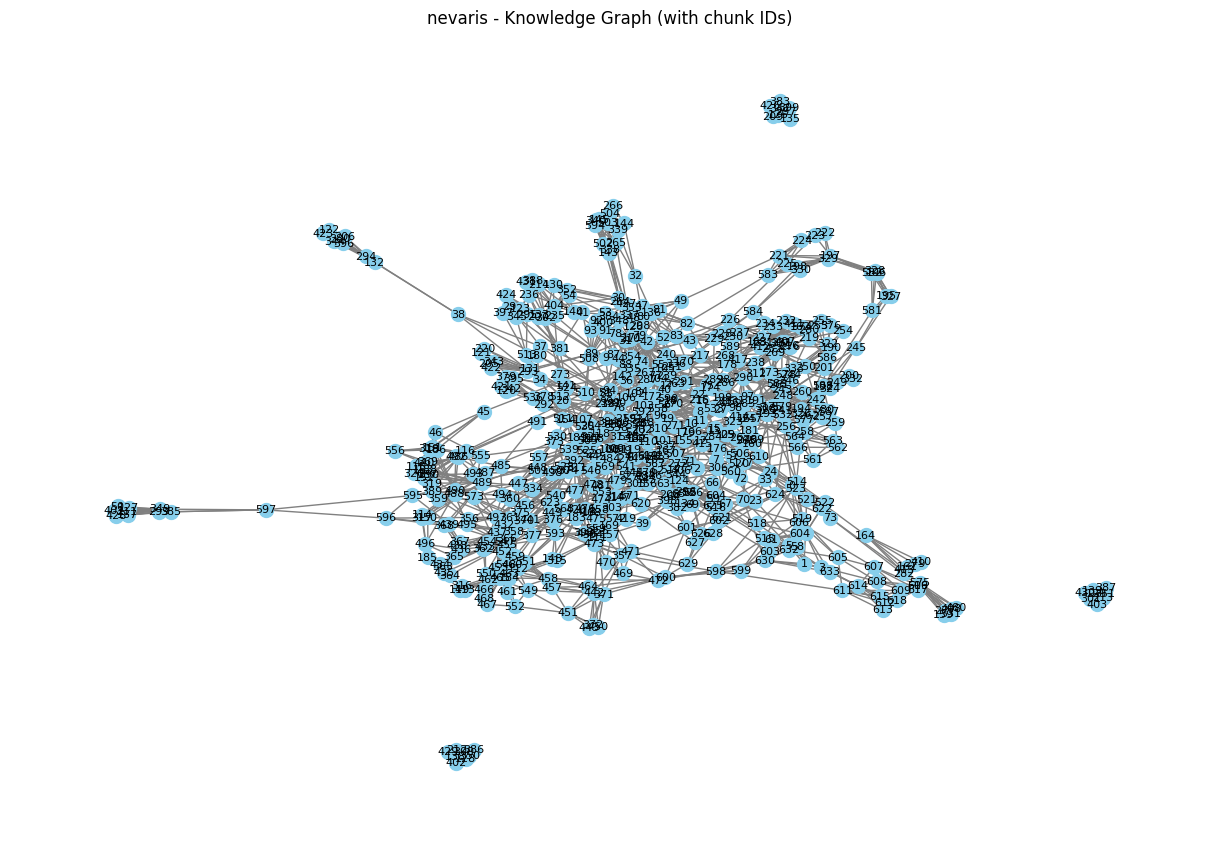

In [24]:
# Visualize the full knowledge graph from Spanner with node IDs as labels

import networkx as nx
import matplotlib.pyplot as plt
from google.cloud import spanner

spanner_client = spanner.Client()
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)

# Fetch nodes
with database.snapshot() as snapshot:
    node_rows = list(snapshot.execute_sql("SELECT NodeId FROM KgNode"))
    nodes = [row[0] for row in node_rows]

# Fetch edges (unique undirected)
with database.snapshot() as snapshot:
    edge_rows = list(snapshot.execute_sql("""
        SELECT DISTINCT LEAST(SourceId, TargetId) AS n1, GREATEST(SourceId, TargetId) AS n2
        FROM KgEdge
    """))
    edges = [(row[0], row[1]) for row in edge_rows if row[0] != row[1]]

# Build the NetworkX graph
G_full = nx.Graph()
G_full.add_nodes_from(nodes)
G_full.add_edges_from(edges)

# Visualize the full graph with node IDs as labels
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_full, seed=42)
nx.draw(
    G_full, pos,
    node_size=100,
    node_color="skyblue",
    edge_color="gray",
    with_labels=False
)
nx.draw_networkx_labels(G_full, pos, labels={n: str(n) for n in G_full.nodes()}, font_size=8)
plt.title(f"{brand_name} - Knowledge Graph (with chunk IDs)")
plt.axis("off")
plt.show();

In [59]:
# with database.snapshot() as snapshot:
#     results = list(snapshot.execute_sql("SELECT NodeId, Content FROM KgNode LIMIT 10"))
#     for node_id, content in results:
#         print(f"NodeId: {node_id}, Content: {content[:100]}")

In [60]:
# from langchain_google_spanner import SpannerGraphTextToGQLRetriever

# retriever = SpannerGraphTextToGQLRetriever.from_params(
#     graph_store=graph_store,
#     # embedding_service=embedding_service,
#     # embeddings_column="Embedding",
#     text_column="Concepts",  # Use the Content column for keyword search
#     llm=llm
# )

# results = retriever.invoke(question)
# results

In [ ]:
# GRAPH Allplan
# MATCH p = (a)-[e]->(b)
# RETURN TO_JSON(p) AS path_json

In [26]:
# with database.snapshot() as snapshot:
#     results = list(snapshot.execute_sql("SELECT NodeId, Embedding FROM KgNode LIMIT 5"))
#     for node_id, embedding in results:
#         print(f"NodeId: {node_id}, Embedding: {embedding[:5] if embedding else embedding}")